In [1]:
import numpy as np
import torch
import torch.nn.functional as F
from pathlib import Path
import torchvision.models as models
from torchsummary import summary
import glob
import random
from torch.utils.data.sampler import SubsetRandomSampler, WeightedRandomSampler
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from matplotlib import pyplot as plt
import cv2
from PIL import Image
from gradcam import GradCAM
from gradcam.utils import visualize_cam

## Create the np files for data and store.

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

print('Device is {}'.format(device))
if str(device) == 'cuda':
    print(f'CUDA device {torch.cuda.device(0)}')
    print(f'Number of devices: {torch.cuda.device_count()}')
    print(f'Device name: {torch.cuda.get_device_name(0)}')

Device is cuda
CUDA device <torch.cuda.device object at 0x00000212FCC5C250>
Number of devices: 1
Device name: GeForce RTX 2070 SUPER


In [3]:
fimages = []
datapath = Path(r'D:\school\ComputerVision\project')
fimages.extend(datapath.glob('thumbnails*/*.png'))
# fimages = fimages[:11000]
fimages.extend(datapath.glob('*MFD/*/*.jpg'))
fimages.extend(datapath.glob('RMFD/*/*/*.jpg'))
fimages.extend(datapath.glob('RMFD/*/*/*.png'))
random.shuffle(fimages)
ntrain, nval = int(len(fimages) * 0.7), int(len(fimages) * 0.85)
ftrain, fval, ftest = fimages[:ntrain], fimages[ntrain:nval], fimages[nval:]

In [4]:
dataset_class = [get_class(x) for x in fimages]

NameError: name 'get_class' is not defined

In [ ]:
fig = plt.figure()
y = [dataset_class.count(x) for x in np.arange(5)]
y[0] += y[3]
y.pop(3)
plt.bar(np.arange(4), y)
plt.xticks(np.arange(4), ['No mask', 'Correctly masked (Synthetic)', 'Incorrectly masked (Synthetic)',
                          'Correctly masked (real)'], rotation=15)
plt.ylabel('Number of images')
fig.tight_layout()
plt.savefig('dataset.png')
y

In [5]:
# plt.figure(figsize=(16,10))
# plt.imshow(np.hstack(train_images[:10]))
# print(train_labels[:10])

In [4]:
def get_class(fimage):
    if 'CMFD' in str(fimage):
        label = 1
    elif 'IMFD' in str(fimage):
        label = 2
    elif 'thumbnails' in str(fimage):
        label = 0
    elif 'AFDB_face_dataset' in str(fimage):
        label = 3
    elif 'AFDB_masked_face_dataset' in str(fimage):
        label = 4
    else:
        raise NotImplementedError
    return label

class MaskFaceDataset(Dataset):
    def __init__(self, fimages, tform=None):
        self.fimages = fimages
        self.transform = tform
    def __len__(self):
        return len(self.fimages)

    def __getitem__(self, idx):
        fimage = self.fimages[idx]
        image = Image.open(fimage)
        if 'CMFD' in str(fimage) or 'AFDB_masked_face_dataset' in str(fimage):
            label = 1
        elif 'IMFD' in str(fimage):
            label = 2
        elif 'thumbnails' in str(fimage) or 'AFDB_face_dataset' in str(fimage):
            label = 0
        else:
            raise NotImplementedError
        # image, label = Image.fromarray(self.images[idx, :, :, :].copy().astype(np.uint8)), torch.tensor(self.labels[idx])
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label).long()

In [5]:
class RealFaceDataset(Dataset):
    def __init__(self, fimages, tform=None):
        self.fimages = fimages
        self.transform = tform

    def __len__(self):
        return len(self.fimages)

    def __getitem__(self, idx):
        fimage = self.fimages[idx]
        label = 1 if 'masked' in str(fimage) else 0
        image = Image.open(fimage)
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label).long()

In [6]:
def create_weighted_sampler(fimages, nimages):
    dataset_class = [get_class(x) for x in fimages]
    class_count = [dataset_class.count(x) for x in range(5)]
    class_count[2] /= 2
    weight = 1. / np.array(class_count)
    samples_weight = np.array([weight[get_class(x)] for x in fimages])
    samples_weight = torch.from_numpy(samples_weight).double()
    return WeightedRandomSampler(samples_weight, nimages, replacement=False)

In [7]:
tforms_train = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomAffine(degrees = 180, scale=(0.8,1.2)),
    transforms.RandomPerspective(distortion_scale=0.5),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor()
])

tforms_val = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomAffine(degrees = 180, scale=(0.8,1.2)),
    transforms.RandomPerspective(distortion_scale=0.5),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor()
])

tforms_test = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

batch_size = 256
train_set = MaskFaceDataset(fimages=ftrain, tform=tforms_train)
val_set = MaskFaceDataset(fimages=fval, tform=tforms_val)
test_set = MaskFaceDataset(fimages=ftest, tform=tforms_test)

indices = list(range(len(train_set)))
np.random.shuffle(indices)
train_loader = DataLoader(train_set, sampler=create_weighted_sampler(ftrain, 50000), batch_size=batch_size, drop_last=True)
val_loader = DataLoader(val_set, sampler=create_weighted_sampler(fval, 5000), batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_set, sampler=create_weighted_sampler(ftest, 5000), batch_size=batch_size, drop_last=True)

(19, 128, 128, 3)


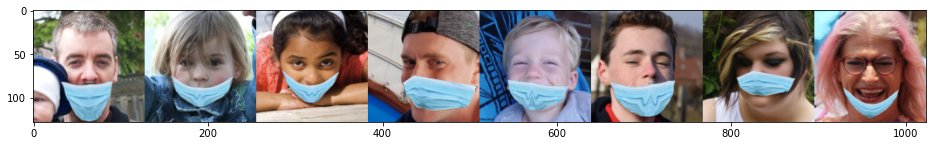

In [9]:
aug_img = []
x, y = next(iter(test_loader))
for i in range(0,50):
    if y[i] == 2:
        aug_img.append(x[i,:,:,:].permute(1, 2, 0).numpy())
print(np.array(aug_img).shape)
plt.figure(figsize=(16,10))
plt.imshow(np.hstack(aug_img[:8]))
plt.savefig('wrong_mask.png')

In [10]:
def evaluate(data_loader, return_failure=False):
    correct, total, batch_loss = 0, 0, 0
    all_pred = []
    all_lab = []
    for x, y in data_loader:
        with torch.no_grad():
            outputs = model(x.to(device)) 
            loss = loss_metric(outputs, y.to(device))
            batch_loss += loss.cpu().detach().numpy()
            _, predicted = torch.max(outputs.data, 1)
            total += y.size(0)
            correct += (predicted.float() == y.float().to(device)).sum()
            all_lab.append(y.float().cpu().numpy())
            all_pred.append(predicted.float().cpu().numpy())
    acc = correct.cpu().numpy() / total * 100
    print('Accuracy: %f %%' % acc)
    return batch_loss / len(data_loader), acc, all_pred, all_lab

In [70]:
learning_rate = 1e-4
epochs = 50
# model = models.resnet18(pretrained=True)
#
# model.fc = torch.nn.Linear(in_features=512, out_features=3, bias=True)
# model.to(device)

summary(model, input_size=(3, 128, 128))

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_metric = torch.nn.CrossEntropyLoss()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

In [12]:
dckpt = Path(r'D:\school\ComputerVision\project\ckpt')
train_loss, val_loss, train_acc, val_acc = [], [], [], []
best_acc = 0
for epoch in range(epochs):
    model.train()
    for i, (x, y) in enumerate(train_loader):
        if i > 0 or epoch > 0:
            optimizer.zero_grad()
        x, y = x.to(device), y.to(device)
        outputs = model(x)
        loss = loss_metric(outputs, y)
        loss.backward()
        optimizer.step()

    model.eval()
    print('Epoch {}:'.format(epoch))
    train_eval_loss, train_eval_acc,_,_ = evaluate(train_loader)
    
    print('Training loss = {}'.format(train_eval_loss))
    train_acc.append(train_eval_acc)
    train_loss.append(train_eval_loss)
    
    val_eval_loss, val_eval_acc,_,_ = evaluate(val_loader)
    val_loss.append(val_eval_loss)
    val_acc.append(val_eval_acc)
    if val_eval_acc > best_acc:
        torch.save(model, './fullmodel.h5py')
        best_acc = val_eval_acc
    print('Validation loss = {}'.format(val_eval_loss))
    torch.save(model.state_dict(), dckpt / 'model_checkpoint_epoch_{}.pth'.format(epoch))

Epoch 0:
Accuracy: 97.471955 %
Training loss = 0.0751640012440009
Accuracy: 95.764803 %
Validation loss = 0.12733066101607524
Epoch 1:
Accuracy: 98.377404 %
Training loss = 0.052233226052843605
Accuracy: 97.101151 %
Validation loss = 0.08749140152021458
Epoch 2:
Accuracy: 98.547676 %
Training loss = 0.0471453621219366
Accuracy: 97.388980 %
Validation loss = 0.07610369454088964
Epoch 3:
Accuracy: 99.246795 %
Training loss = 0.027666058871321952
Accuracy: 98.375822 %
Validation loss = 0.05047374909841701
Epoch 4:
Accuracy: 99.174679 %
Training loss = 0.029846562958585145
Accuracy: 98.581414 %
Validation loss = 0.04488147398162829
Epoch 5:
Accuracy: 99.354968 %
Training loss = 0.02386176999276265
Accuracy: 98.787007 %
Validation loss = 0.04193583513168912
Epoch 6:
Accuracy: 99.258814 %
Training loss = 0.027094525829530678
Accuracy: 98.601974 %
Validation loss = 0.04370509009612234
Epoch 7:
Accuracy: 99.318910 %
Training loss = 0.02286996357501126
Accuracy: 98.581414 %
Validation loss = 0.

KeyboardInterrupt: 

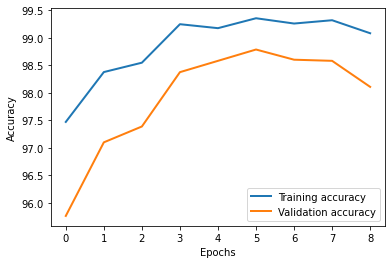

In [17]:
plt.plot(train_acc, lw=2)
plt.plot(val_acc, lw=2)
plt.legend(('Training accuracy','Validation accuracy'))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.savefig('acc.png')



In [67]:
def fail_evaluate(data_loader, return_failure=False):
    correct, total, batch_loss = 0, 0, 0
    all_pred = []
    all_lab = []
    failures = []
    for x, y in data_loader:
        with torch.no_grad():
            outputs = model(x.to(device)) 
            loss = loss_metric(outputs, y.to(device))
            batch_loss += loss.cpu().detach().numpy()
            _, predicted = torch.max(outputs.data, 1)
            total += y.size(0)
            correct += (predicted.float() == y.float().to(device)).sum()
            all_lab.append(y.float().cpu().numpy())
            all_pred.append(predicted.float().cpu().numpy())
            failures.append(x.cpu().numpy()[predicted.float().cpu() != y.float().cpu()])
    acc = correct.cpu().numpy() / total * 100
    
    print('Accuracy: %f %%' % acc)
    return batch_loss / len(data_loader), acc, all_pred, all_lab, failures

In [73]:
model = model.cuda()
test_eval_loss, test_eval_acc,all_predictions, all_labs, failures = fail_evaluate(test_loader)
print('Test loss is', test_eval_loss)

Accuracy: 98.725329 %
Test loss is 0.03441392198989266


In [79]:
failimg = []
for i in range(len(failures)):
    f = failures[i]
    for j in range(len(f)):
        failimg.append(np.rollaxis(f[j], 0, 3))

[[2302   13    5]
 [   3 1163   32]
 [   7    2 1337]]


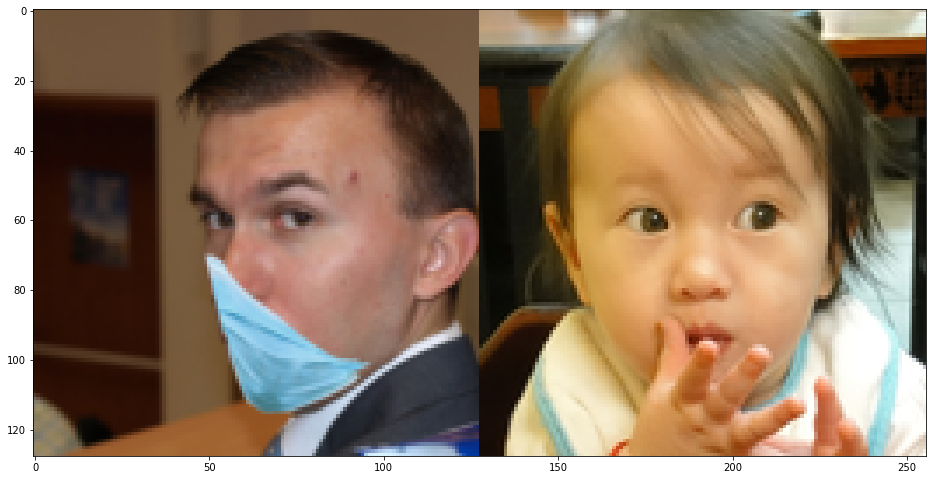

In [96]:
import sklearn.metrics as m
preds = np.array(all_predictions).reshape(-1)
labs = np.array(all_labs).reshape(-1)
conf_matrix = m.confusion_matrix(preds, labs)

print(conf_matrix)
counter = 0
fp = []
tn = []
wronglist = np.argwhere(preds != labs)
for i in range(len(wronglist)):
    if preds[wronglist[i]] == 2:
        tn.append(failimg[i])
    # elif labs[wronglist[i]] == 0 and preds[wronglist[i]] == 2:
    #     fp.append(failimg[i])

plt.figure(figsize=(16,10))
plt.imshow(np.hstack(np.array(tn)[7:14]))
# plt.figure(figsize=(16,10))
# plt.imshow(np.hstack(np.array(fp)[:7]))

In [16]:
torch.save(model, './fullmodel.h5py')
from scipy.io import savemat
savemat('./results.mat',{"train_acc": train_acc, "train_loss": train_loss, "val_loss": val_loss, "val_acc": val_acc})

## Visualization of network

In [78]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

# Compute ROC curve and ROC area for each class
# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# fpr, tpr, _ = roc_curve(labs, preds)
# roc_auc = auc(fpr, tpr)
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes=3
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(labs[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()
# Compute micro-average ROC curve and ROC area
# fpr["micro"], tpr["micro"], _ = roc_curve(labs, preds)
# roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [35]:
def plot_filters_multi_channel(t):
    
    #get the number of kernals
    num_kernels = t.shape[0]    
    
    #define number of columns for subplots
    num_cols = 12
    #rows = num of kernels
    num_rows = num_kernels
    
    #set the figure size
    fig = plt.figure(figsize=(num_cols // 2,num_rows))
    
    #looping through all the kernels
    for i in range(t.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        
        #for each kernel, we convert the tensor to numpy 
        npimg = np.array(t[i].numpy(), np.float32)
        #standardize the numpy image
        npimg = (npimg - np.mean(npimg)) / np.std(npimg)
        npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
        npimg = npimg.transpose((1, 2, 0))
        ax1.imshow(npimg)
        ax1.axis('off')
        ax1.set_title(str(i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        
    plt.savefig('myimage.png')
    plt.tight_layout()
    plt.show()
    
def plot_filters_single_channel(t):
    
    #kernels depth * number of kernels
    nplots = t.shape[0]*t.shape[1]
    ncols = 12
    
    nrows = 1 + nplots//ncols
    #convert tensor to numpy image
    npimg = np.array(t.numpy(), np.float32)
    
    count = 0
    fig = plt.figure(figsize=(ncols, nrows))
    
    #looping through all the kernels in each channel
    for i in range(t.shape[0]):
        for j in range(t.shape[1]):
            count += 1
            ax1 = fig.add_subplot(nrows, ncols, count)
            npimg = np.array(t[i, j].numpy(), np.float32)
            npimg = (npimg - np.mean(npimg)) / np.std(npimg)
            npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
            ax1.imshow(npimg)
            ax1.set_title(str(i) + ',' + str(j))
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
   
    plt.tight_layout()
    plt.show()

torch.Size([64, 3, 7, 7])


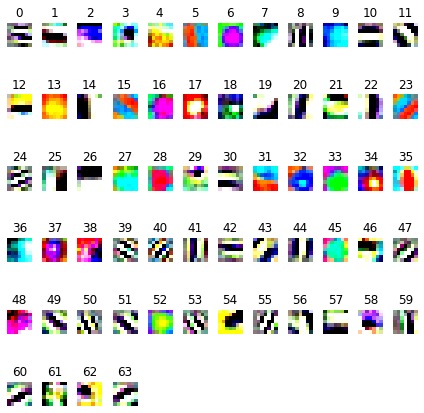

In [36]:
def plot_weights(model, layer_num, single_channel = True, collated = False):
  
  #extracting the model features at the particular layer number
  layer = model.conv1
  
  #checking whether the layer is convolution layer or not 
  if isinstance(layer, torch.nn.Conv2d):
    #getting the weight tensor data
    weight_tensor = layer.weight.data
    print(weight_tensor.shape)
    if single_channel:
      if collated:
        plot_filters_single_channel(weight_tensor)
      else:
        plot_filters_single_channel(weight_tensor)
        
    else:
      
      if weight_tensor.shape[1] == 3:
        plot_filters_multi_channel(weight_tensor)
      else:
        print("Can only plot weights with three channels with single channel = False")
        
  else:
    print("Can only visualize layers which are convolutional")
        
#visualize weights for alexnet - first conv layer
plot_weights(model.cpu(), 0, single_channel = False)

In [31]:
class SaveFeatures():
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = torch.tensor(output,requires_grad=True).cuda()
    def close(self):
        self.hook.remove()

class FilterVisualizer():
    def __init__(self, size=56, upscaling_steps=12, upscaling_factor=1.2):
        self.size, self.upscaling_steps, self.upscaling_factor = size, upscaling_steps, upscaling_factor
        self.model = model.cuda().eval()
#         set_trainable(self.model, False)

    def visualize(self, layer, filter, lr=0.1, opt_steps=20, blur=None):
        sz = self.size
        img = np.uint8(np.random.uniform(128, 128, (sz, sz, 3)))/255  # generate random image
        activations = SaveFeatures(list(self.model.children())[layer])  # register hook

        for _ in range(self.upscaling_steps):  # scale the image up upscaling_steps times
            train_tfms, val_tfms = tfms_from_model(vgg16, sz)
            img_var = V(val_tfms(img)[None], requires_grad=True)  # convert image to Variable that requires grad
            optimizer = torch.optim.Adam([img_var], lr=lr, weight_decay=1e-6)
            for n in range(opt_steps):  # optimize pixel values for opt_steps times
                optimizer.zero_grad()
                self.model(img_var)
                loss = -activations.features[0, filter].mean()
                loss.backward()
                optimizer.step()
            img = val_tfms.denorm(img_var.data.cpu().numpy()[0].transpose(1,2,0))
            self.output = img
            sz = int(self.upscaling_factor * sz)  # calculate new image size
            img = cv2.resize(img, (sz, sz), interpolation = cv2.INTER_CUBIC)  # scale image up
            if blur is not None: img = cv2.blur(img,(blur,blur))  # blur image to reduce high frequency patterns
        self.save(layer, filter)
        activations.close()
        
    def save(self, layer, filter):
        plt.imsave("layer_"+str(layer)+"_filter_"+str(filter)+".jpg", np.clip(self.output, 0, 1))

In [32]:
layer = 1
filter = 265
FV = FilterVisualizer(size=56, upscaling_steps=12, upscaling_factor=1.2)
FV.visualize(layer, filter, blur=5)

NameError: name 'tfms_from_model' is not defined

In [12]:
fimages = []
datapath = Path(r'D:\school\ComputerVision\project')
fimages.extend(datapath.glob('RMFD/*/*/*.jpg'))
fimages.extend(datapath.glob('RMFD/*/*/*.png'))

datapath = Path(r'D:\school\ComputerVision\project')
fimages = []
fimages.extend(datapath.glob('RMFD/*/*/*.jpg'))
fimages.extend(datapath.glob('RMFD/*/*/*.png'))

random.shuffle(fimages)
ntrain, nval = int(len(fimages) * 0.7), int(len(fimages) * 0.85)
ftrain, fval, ftest = fimages[:ntrain], fimages[ntrain:nval], fimages[nval:]

batch_size = 256
real_train_set = RealFaceDataset(fimages=ftrain, tform=tforms_train)
real_val_set = RealFaceDataset(fimages=fval, tform=tforms_val)
real_test_set = RealFaceDataset(fimages=ftest, tform=tforms_test)

real_train_loader = DataLoader(real_train_set, sampler=create_weighted_sampler(ftrain, len(ftrain)), batch_size=batch_size, drop_last=True)
real_val_loader = DataLoader(real_val_set, sampler=create_weighted_sampler(fval, len(fval)), batch_size=batch_size, drop_last=True)
real_test_loader = DataLoader(real_test_set, sampler=create_weighted_sampler(ftest, len(ftest)), batch_size=batch_size, drop_last=True)

learning_rate = 5e-4
epochs = 20
model = models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(in_features=512, out_features=3, bias=True)
model.to(device)
model.cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
dckpt = Path(r'D:\school\ComputerVision\project\tune_ckpt')
train_loss, val_loss, train_acc, val_acc = [], [], [], []
for epoch in range(epochs):
    model.train()
    for i, (x, y) in enumerate(real_train_loader):
        if i > 0 or epoch > 0:
            optimizer.zero_grad()
        x, y = x.to(device), y.to(device)
        outputs = model(x)
        loss = loss_metric(outputs, y)
        loss.backward()
        optimizer.step()

    model.eval()
    print('Epoch {}:'.format(epoch))
    train_eval_loss, train_eval_acc,_,_ = evaluate(real_train_loader)

    print('Training loss = {}'.format(train_eval_loss))
    train_acc.append(train_eval_acc)
    train_loss.append(train_eval_loss)

    val_eval_loss, val_eval_acc,_,_ = evaluate(real_val_loader)
    val_loss.append(val_eval_loss)
    val_acc.append(val_eval_acc)
    print('Validation loss = {}'.format(val_eval_loss))
    torch.save(model.state_dict(), dckpt / 'model_checkpoint_epoch_{}.pth'.format(epoch))

Epoch 0:
Accuracy: 97.643898 %
Training loss = 0.1401739217248458
Accuracy: 97.641782 %
Validation loss = 0.14058244193007272
Epoch 1:
Accuracy: 97.643898 %
Training loss = 0.10787780109467168
Accuracy: 97.641782 %
Validation loss = 0.1103094915392662
Epoch 2:
Accuracy: 97.724185 %
Training loss = 0.06581565601545986
Accuracy: 97.706887 %
Validation loss = 0.06764300308768051
Epoch 3:
Accuracy: 98.079298 %
Training loss = 0.044106565006104895
Accuracy: 98.104745 %
Validation loss = 0.04562900020068304
Epoch 4:
Accuracy: 98.395813 %
Training loss = 0.03584488153732805
Accuracy: 98.466435 %
Validation loss = 0.035781981042991566
Epoch 5:
Accuracy: 98.647480 %
Training loss = 0.03052308463437203
Accuracy: 98.748553 %
Validation loss = 0.030097104331987253
Epoch 6:
Accuracy: 98.879076 %
Training loss = 0.026151164834711537
Accuracy: 98.914931 %
Validation loss = 0.026756333667974645
Epoch 7:
Accuracy: 99.025753 %
Training loss = 0.024113026719306607
Accuracy: 98.914931 %
Validation loss = 

KeyboardInterrupt: 

In [15]:
test_eval_loss, test_eval_acc,all_predictions, all_labs, failures = fail_evaluate(real_test_loader)
print('Test loss is', test_eval_loss)
torch.save(model, './fullmodel.h5py')

Accuracy: 99.110243 %
Test loss is 0.020177649697062507


In [15]:
model = torch.load(r'D:\school\ComputerVision\project\3way_ckpt\3class_model.h5py')
from scipy.io import savemat, loadmat
results = loadmat(r'D:\school\ComputerVision\project\3way_ckpt\results.mat')

In [42]:
tforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])
classes = ('Unmasked', 'Masked', 'Incorrect')
for i in range(100):
    face_image = np.load('yolov4-deepsort/face.npy')
    face_image = tforms(Image.fromarray(face_image)).view(1, 3, 128, 128).cuda()
    with torch.no_grad():
        outputs = model(face_image)
        prediction = classes[torch.argmax(outputs)]
del face_image
print(prediction)

Unmasked


In [16]:
classes = ('Unmasked', 'Masked', 'Incorrect')

'Unmasked'

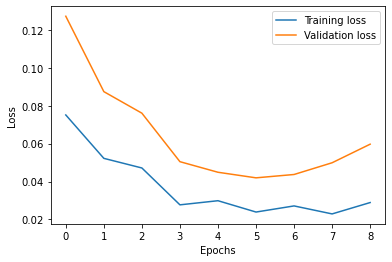

In [22]:
plt.plot(np.arange(9), results['train_loss'].reshape(-1))
plt.plot(np.arange(9), results['val_loss'].reshape(-1))
plt.legend(('Training loss', 'Validation loss'))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('loss.png')

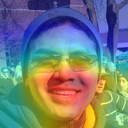

In [110]:
model = model.cpu()
test_loader = DataLoader(test_set, sampler=create_weighted_sampler(ftest, 5000), batch_size=1, drop_last=True)
gradcam = GradCAM.from_config(model_type='resnet', arch=model, layer_name='layer4')
# x, y = next(iter(test_loader))
x = torch.tensor(tn[1].transpose(2,0,1).reshape(1, 3, 128, 128))
mask, _ = gradcam(x, class_idx=0)
heatmap, result = visualize_cam(mask, x)
transforms.ToPILImage()(result)